# Code Lab 3C: RNN for Text Classification

This notebook consist of 4 main sections:

1. Preparing the data
2. Implementing a simple LSTM (RNN) model
3. Training the model
4. Evaluating the model

**Key Model Parameters**

In [0]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 20 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

**Download the `GloVe` file if it is not present at `GLOVE_DIR`**

In [2]:
# download pre-trained GloVe vectors

import keras

GLOVE_URL = "https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/glove.6B.100d.txt.zip"
GLOVE_DIR = keras.utils.get_file("glove.6B.100d.txt.zip", GLOVE_URL, cache_subdir='datasets', extract=True)
print("GloVe data present at", GLOVE_DIR)
GLOVE_DIR = GLOVE_DIR.replace(".zip", "")

Using TensorFlow backend.


134414336/134409644 [==============================] - 11s 0us/step
GloVe data present at /root/.keras/datasets/glove.6B.100d.txt.zip


In [0]:
import numpy as np
import re, sys, csv, pickle
from tqdm import tqdm_notebook

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

### 1. Prepare the data

**Preprocessing Step**

Removing [stopwords](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html), punctuation and making everything lowercase.

In [0]:
#import nltk
#nltk.download('stopwords')

In [0]:
from nltk.corpus import stopwords
def clean_text(text, remove_stopwords=False):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

**Reading from Dataset**

In [6]:
DATA_URL = "https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/stanford_movie.zip"
DATA_DIR = keras.utils.get_file("stanford_movie.zip", DATA_URL, cache_subdir='datasets', extract=True)
print("Dataset present at", DATA_DIR)
DATA_DIR = DATA_DIR.replace(".zip", "")

466944/464671 [==============================] - 1s 2us/step
Dataset present at /root/.keras/datasets/stanford_movie.zip


In [7]:
texts = []   # empty list for model input: the movie reviews
labels = []  # empty lists model output: sentiment labels

data_neg = open(DATA_DIR+"/stanford_movie_neg.txt", "rb") 
for line in tqdm_notebook(data_neg, total=5331): 
    texts.append(clean_text(line))
    labels.append(int(0))

In [8]:
data_pos = open(DATA_DIR+"/stanford_movie_pos.txt", "rb") 
for line in tqdm_notebook(data_pos, total=5331): 
    texts.append(clean_text(line))
    labels.append(int(1))

In [9]:
print("Sample negative:", texts[0], labels[0])
print("Sample positive:", texts[9000], labels[9000])

Sample negative: simplistic silly and tedious 0
Sample positive: with few respites marshall keeps the energy humming and his edits unlike those in moulin rouge are crisp and purposeful without overdoing it 1


**Word Tokenizer**

In [10]:
CACHE_TOKENIZER = False

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

if CACHE_TOKENIZER:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("[i] Saved word tokenizer to file: tokenizer.pickle")

# to use cached tokenizer:
"""
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
"""

"\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n"

**Generate the array of sequences from dataset**

In [11]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Vocabulary size:', len(word_index))
data = pad_sequences(sequences, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Vocabulary size: 20659


**Create the train-validation split**

In [12]:
labels = to_categorical(np.asarray(labels)) # convert the category label to one-hot encoding
print('[i] Shape of data tensor:', data.shape)
print('[i] Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:",y_train.sum(axis=0))
print("[+] Validation:",y_val.sum(axis=0))

[i] Shape of data tensor: (10662, 20)
[i] Shape of label tensor: (10662, 2)
[i] Number of entries in each category:
[+] Training: [4277. 4253.]
[+] Validation: [1054. 1078.]


**What does the data look like?**

In [13]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [ 178  550  236  130    5 5609  221    2 8753   13   12  627  287   22
   64 1296    0    0    0    0]

One-hot label:
 [1. 0.]


### 2. Create the model

We will now start to create the model in `Keras`.

**Load word embeddings into an `embeddings_index`**

Create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.

We use a set from [pre-trained GloVe vectors from Stanford](https://nlp.stanford.edu/projects/glove/).

In [14]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] (long) Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(" Completed!")

[i] (long) Loading GloVe from: /root/.keras/datasets/glove.6B.100d.txt ...Done.
[+] Proceeding with Embedding Matrix... Completed!


**Create the `Embedding` layers**

In [15]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # input to the model

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False, name="embeddings")

embedded_sequences = embedding_layer(sequence_input)

W0812 16:48:13.244079 140553569064832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 16:48:13.286590 140553569064832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 16:48:13.294749 140553569064832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 16:48:13.306820 140553569064832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0812 16:48:13.307673 1405535690

In [0]:
l_lstm = CuDNNLSTM(256)(embedded_sequences) # CuDNNLSTM is available on CUDA-capable machines

In [17]:
l_drop = Dropout(0.5)(l_lstm)
l_dense = Dense(32, activation='relu')(l_drop)
preds = Dense(2, activation='softmax')(l_dense) # follows the number of classes

W0812 16:48:18.175883 140553569064832 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Compile the model into a static graph for training**

In [18]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])
model.summary()

W0812 16:48:18.222200 140553569064832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 16:48:18.246509 140553569064832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embeddings (Embedding)       (None, 20, 100)           2066000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               366592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 2,440,882
Trainable params: 374,882
Non-trainable params: 2,066,000
____________________________________________________________

**Visualisation**

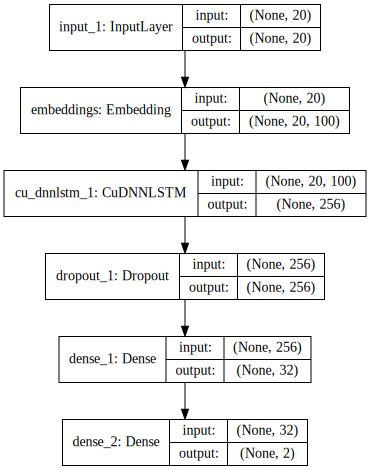

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 3. Train the model

In [20]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      epochs=15, batch_size=128)

Training Progress:
Train on 8530 samples, validate on 2132 samples
Epoch 1/15
8530/8530 [==============================] - 4s 510us/step - loss: 0.6894 - acc: 0.5504 - val_loss: 0.6355 - val_acc: 0.6501
Epoch 2/15
8530/8530 [==============================] - 0s 50us/step - loss: 0.6179 - acc: 0.6583 - val_loss: 0.5733 - val_acc: 0.6937
Epoch 3/15
8530/8530 [==============================] - 0s 50us/step - loss: 0.5709 - acc: 0.7103 - val_loss: 0.5584 - val_acc: 0.7083
Epoch 4/15
8530/8530 [==============================] - 0s 50us/step - loss: 0.5499 - acc: 0.7217 - val_loss: 0.5470 - val_acc: 0.7186
Epoch 5/15
8530/8530 [==============================] - 0s 49us/step - loss: 0.5304 - acc: 0.7369 - val_loss: 0.5364 - val_acc: 0.7261
Epoch 6/15
8530/8530 [==============================] - 0s 52us/step - loss: 0.5076 - acc: 0.7450 - val_loss: 0.5231 - val_acc: 0.7355
Epoch 7/15
8530/8530 [==============================] - 0s 48us/step - loss: 0.5010 - acc: 0.7529 - val_loss: 0.5389 - val

Notice that an RNN-based model trains a lot slower than a CNN.

### 4. Evaluate the model

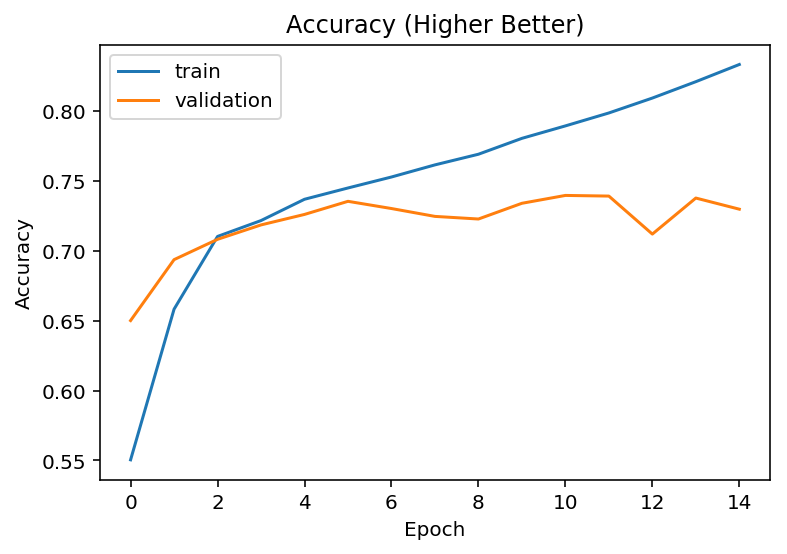

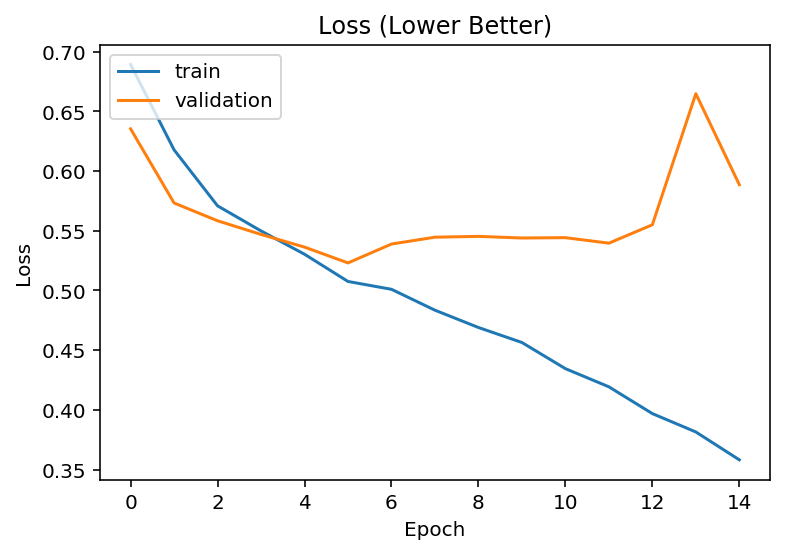

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

classes = ["positive", "negative"]

In [23]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    positive       0.70      0.78      0.74      1054
    negative       0.76      0.68      0.72      1078

    accuracy                           0.73      2132
   macro avg       0.73      0.73      0.73      2132
weighted avg       0.73      0.73      0.73      2132



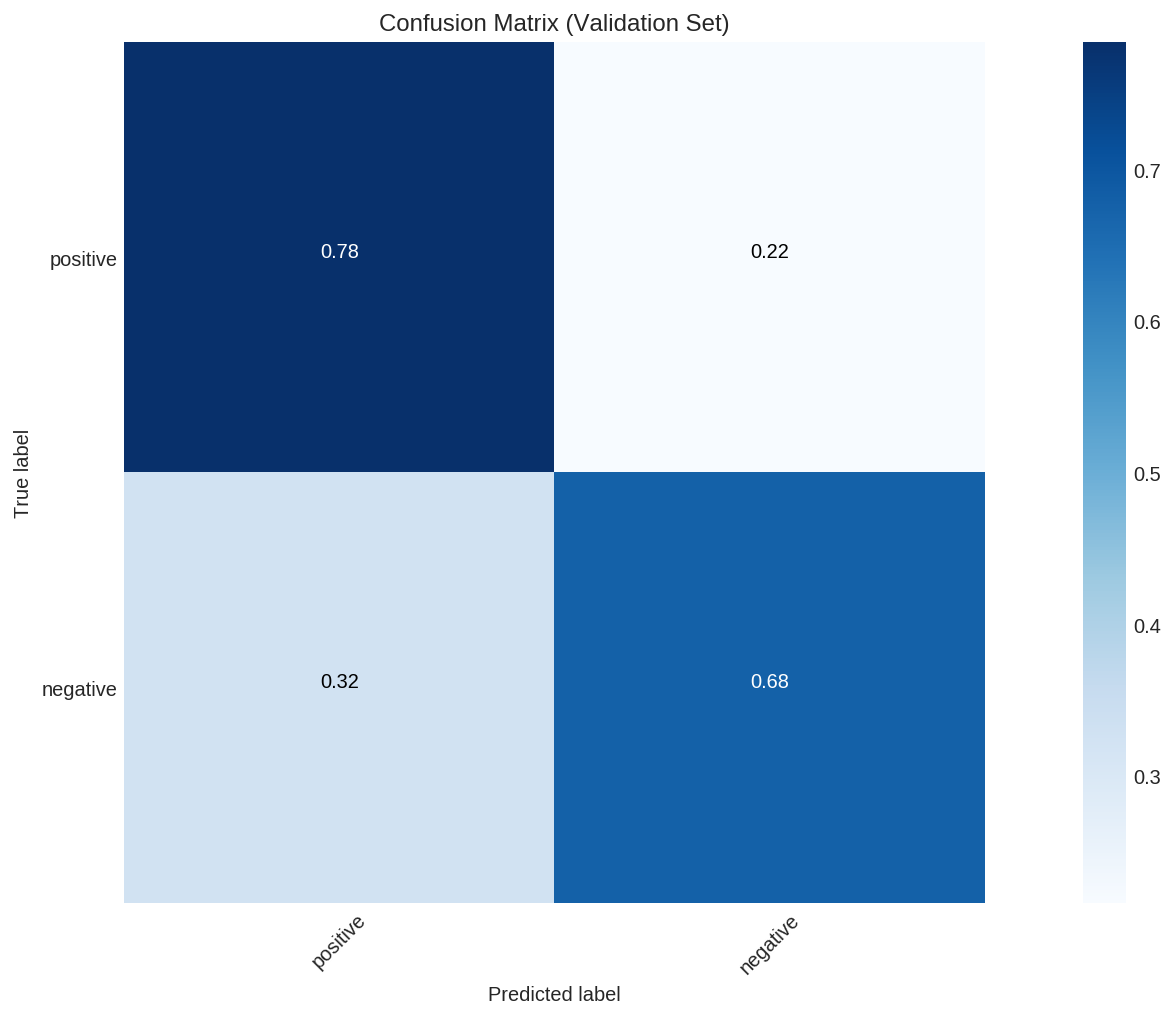

In [24]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
plot_confusion_matrix(cnf_matrix, labels=classes)